Business problem: Customers get Peloton bike delivered and ask, what class should I take first?

Difficulty will be basis of how they choose - build model to predict difficulty based on class daya including roll up stats of playlist.

False Positive - a class is labeled easy, but it isn't
False Negative - a class is not labeled easy, but it is

**Both are equally important to account for - use F1 Score**

Note: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, **micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).**
Source: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [1]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing dfs with heavy processing
import pickle

# Imports Modeling
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, plot_confusion_matrix

# Feat Imp
from yellowbrick.model_selection import FeatureImportances

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# Just in case other pickle files available
# # Opening pickle files
# # Use classId where you can as key for merging
# base_clean_df = pd.read_pickle("../../data/pickled_dfs/base_clean_df.pkl")
# artist_df = pd.read_pickle("../../data/pickled_dfs/artist_df.pkl")
# artist_id_class_count = pd.read_pickle("../../data/pickled_dfs/larger_spot_artist_id_class_count.pkl")  # has artist features
# songs_df = pd.read_pickle("../../data/pickled_dfs/songs_df.pkl")
# song_class_count_df = pd.read_pickle("../../data/pickled_dfs/song_class_count_df.pkl")
# song_class_count_df.rename(columns={'Artist':'Song'}, inplace=True) # Quick clean rename column
# class_type_reorg_df = pd.read_pickle("../../data/pickled_dfs/class_type_reorg_df.pkl")
# new_class_types_with_artists = pd.read_pickle("../../data/pickled_dfs/new_class_types_with_artists.pkl")
# master_song_df = pd.read_pickle("../../data/pickled_dfs/master_song_df.pkl") # has song features
# # artist_id_class_count has 186 rows with 0LyfQWJT6nXafLPZqxe9Of - it means Various Artists
# # and 40 errors

In [3]:
df = pd.read_pickle("../../data/pickled_dfs/master_first_classes_with_stats.pkl")
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music


In [147]:
df['classDifficulty'].describe()

count    6983.000000
mean        7.858991
std         0.778619
min         4.272800
25%         7.554450
50%         8.047400
75%         8.378250
max         9.653600
Name: classDifficulty, dtype: float64

In [148]:
def label_class_diff_cat(classDifficulty):
    if classDifficulty < 7.55:
        return 'Beginner'
    if classDifficulty >= 7.55 and classDifficulty < 8.37:
        return 'Intermediate'
    if classDifficulty >= 8.37:
        return 'Advanced'

In [149]:
# Create classDifficulty_cat for categories of Class Difficulty for classification target
df['classDifficulty_cat'] = df['classDifficulty'].apply(label_class_diff_cat)

In [150]:
#### Create Other Categories Instructor and Class
other_instructors = ['Irène Scholz', 'Erik Jäger', 'Christian Vande Velde', 'Cliff Dwenger',
                     'Alex & Tunde', 'Mayla Wedekind', 'Ally & Emma', 'Cycling Instructors 2019']

df['instructorName'] = df['instructorName'].replace(other_instructors, 'Other')


# Recategorize low count classes
# Create Other category for those <50 
# Put Groove Cody classes into Theme - not a music genre or year, but a programmatic type class like XOXO
df['classCategory'] = df['classCategory'].replace({'Heart Rate Zone' : 'Other',
                                                   'Live DJ' : 'Other',
                                                   'Pro Cyclist' : 'Other',
                                                   'Groove': 'Theme'})

## Modeling

In [151]:
def eval_model(estimator, X_train, X_test, y_train, y_test, target_names, average):
    '''
    Evaluation function to show accuracy, f1 score, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    '''   
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print report
    print(classification_report(y_test, test_preds, target_names=target_names))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds, average=average)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds, average=average)}")
    print(f"F1 Score Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring=(f'f1_{average}')))}")
    
#     # append to df
#     new_row = calc_scores(data_version, estimator, X_train, X_test, y_train, y_test, target_names, average)
#     new_row_df = pd.DataFrame(new_row)
#     frames = [model_results,new_row_df]
#     model_results = pd.concat(frames)
#     model_results.head()
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format='')
    plt.show()

### Data (drop 'Other' categories and time signature- not impactful)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983 entries, 0 to 6982
Data columns (total 36 columns):
classId                 6983 non-null object
className               6983 non-null object
classDescription        6983 non-null object
classDifficulty         6983 non-null float64
classDuration           6983 non-null int64
classType               6983 non-null object
classLength             6983 non-null int64
classLocation           6983 non-null object
classOriginalAirdate    6983 non-null object
classRating             6983 non-null float64
classRatingCount        6983 non-null int64
instructorName          6983 non-null object
instructorBio           6983 non-null object
classEquipment          6983 non-null object
classSongs              6983 non-null object
classArtists            6983 non-null object
classUrl                6983 non-null object
popularity_song         6983 non-null float64
explicit                6983 non-null float64
danceability            6983 non-null

In [153]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation', 'time_signature'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [154]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [155]:
# Copy df for manipulation
scaled_features = df.copy()

In [156]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [157]:
# Copy df for manipulation
ohe_features = df.copy()

In [158]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [159]:
ohe_features = pd.get_dummies(ohe_features)

In [160]:
# Drop Other categories and reset index
ohe_features = ohe_features.drop(columns=['classCategory_Other', 'instructorName_Other']).reset_index(drop=True)

#### Combine

In [161]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [162]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Robin Arzón', 'instructorName_Sam Yo', 'instructorName_Tunde Oyeneyin',
       'classDifficu

In [163]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_cat
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Beginner
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Intermediate
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Intermediate
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner


#### RF with Balanced Class Weight  (rf7 in notebook 91_)

Class weight = 'balanced' to account for 25-50-25 split of Target

In [164]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [165]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Tuning RF - Back down to Max Features = 10

In [166]:
tuned_rf = RandomForestClassifier(max_depth = 9, 
                                    max_features = 10, 
                                    min_samples_leaf = 1,
                                    min_samples_split = 20,
                                    n_estimators = 2000,
                                    random_state=42)

tuned_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## BEST FIT
least amount of overfitting...

              precision    recall  f1-score   support

    Beginner       0.88      0.50      0.63       459
Intermediate       0.87      0.64      0.74       426
    Advanced       0.68      0.92      0.78       861

    accuracy                           0.74      1746
   macro avg       0.81      0.69      0.72      1746
weighted avg       0.78      0.74      0.73      1746

Train Scores
------------
Accuracy: 0.7995035325568073
F1 Score: 0.7995035325568073
--------------------
Test Scores
-----------
Accuracy: 0.7428407789232532
F1 Score: 0.7428407789232532
F1 Score Mean Cross Val 3-Fold: 0.7215963134729567


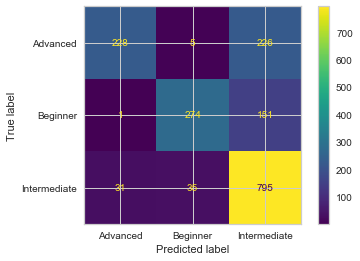

In [167]:
eval_model(tuned_rf, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# Similar to tuned_rf13 in terms of overfitting, but higher scores
# Interesting notes:
## Beginner and Intermediate have best precision - avoiding false positive - categorizing advanced class as beg/int when not
## Advanced has best recall - avoiding false negative categorizing advanced class as not advanced when it is
## Beginner has worst f1
## Best of both worlds - Beginner and Intermediate riders should be protected fom getting an advanced class diguised as 
## easy or intermediate
## Advanced riders want the advanced classes. Best case is satisfying need for true positives.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


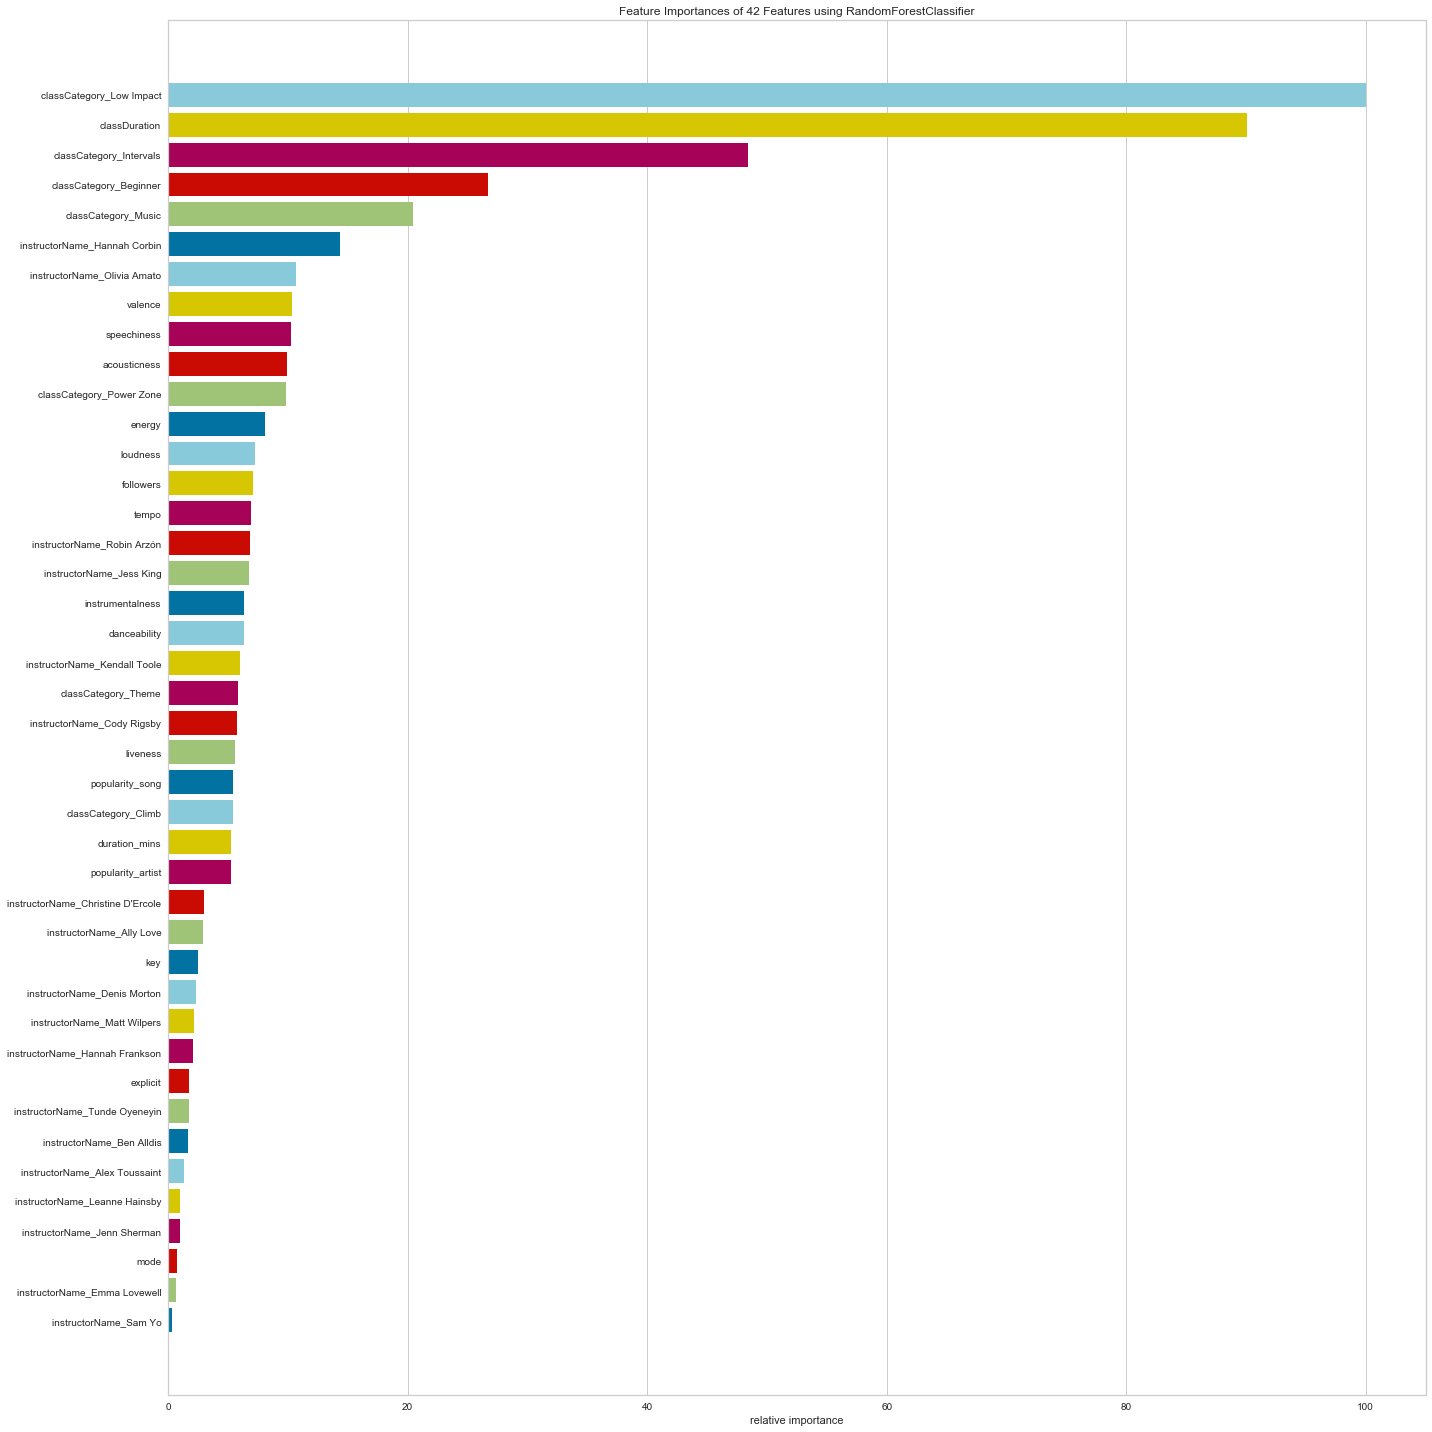

In [168]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf)
viz.fit(X, y)
viz.show()

## Analysis

Note to self: look back at phase 2 project for groupbys and phase 3 project for analysis plots

### Low Impact

In [169]:
df[df['classCategory'] == 'Low Impact'].groupby(by='classDifficulty_cat')['classId'].count()

classDifficulty_cat
Beginner        552
Intermediate      4
Name: classId, dtype: int64

#### Learning: It's clear when classCategory = Low Impact the model uses this to categorize a beginner class

### classDuration

In [170]:
low_im = df[df['classCategory'] == 'Low Impact']

In [171]:
low_im.groupby(by='classDifficulty_cat').agg({'classDuration': ['mean', 'median']})

classDuration       
                             mean median
classDifficulty_cat                     
Beginner                21.621377     20
Intermediate            38.750000     45

In [172]:
pd.DataFrame(df.groupby(['classDuration', 'classDifficulty_cat'])['classId'].count())
# how do I get classDifficulty_cat at columns and do a count...?
# then will translate this into a stacked bar chart
# pivot tables 
# Cdict: class duration key, counts as values

classId
classDuration classDifficulty_cat         
10            Advanced                   8
              Beginner                 189
              Intermediate              55
15            Advanced                  34
              Beginner                 171
              Intermediate             113
20            Advanced                 184
              Beginner                 788
              Intermediate             777
30            Advanced                 651
              Beginner                 388
              Intermediate            1711
45            Advanced                 832
              Beginner                 160
              Intermediate             748
60            Advanced                  66
              Beginner                  35
              Intermediate              60
75            Beginner                   1
              Intermediate               5
90            Intermediate               7

#### Learning: 
- 10 min class assocaited with beginner
- 15 or 20 mins either beginner or intermediate
- 30 mins basically represented the 25/50/25 split established in creation of the target. This makes sense as it is the majority of classes
- 45 or 60 mins is intermediate or advanced
- 75 or 90 mins is intermediate - when looking at the data this doesn't check out. but as a rider, these are endurance rides, not high impact and "pushing"/"maxing out" efforts.

In [173]:
# df.set_axis(df.columns, axis=1,inplace=False).groupby(['classDuration'])['classDifficulty_cat'].count()

classDuration
10     252
15     318
20    1749
30    2750
45    1740
60     161
75       6
90       7
Name: classDifficulty_cat, dtype: int64

In [174]:
# # Stack bar plot sample code
# # https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot

# # set the figure size
# plt.figure=(figsize=(20,10))
# sns.barplot()

# # top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
# total = tips.groupby('day')['total_bill'].sum().reset_index()

# # bar chart 1 -> top bars (group of 'smoker=No')
# bar1 = sns.barplot(x="day",  y="total_bill", data=total, color='darkblue')

# # bottom bar ->  take only smoker=Yes values from the data
# smoker = tips[tips.smoker=='Yes']

# # bar chart 2 -> bottom bars (group of 'smoker=Yes')
# bar2 = sns.barplot(x="day", y="total_bill", data=smoker, estimator=sum, ci=None,  color='lightblue')

# # add legend
# top_bar = mpatches.Patch(color='darkblue', label='smoker = No')
# bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
# plt.legend(handles=[top_bar, bottom_bar])

# # show the graph
# plt.show()

SyntaxError: invalid syntax (<ipython-input-174-e17098c7b519>, line 5)

### classCategory Intervals, Beginner, Music
stacked barchart of class categories - can do these 3 but also low impact

In [175]:
class_cat_drivers = ['Intervals','Beginner','Music']
cat_driver_df = df[df['classCategory'].isin(class_cat_drivers)]

In [176]:
pd.DataFrame(cat_driver_df.groupby(['classCategory', 'classDifficulty_cat'])['classId'].count())
# how do I get classDifficulty_cat at columns and do a count...?
# then will translate this into a bar chart

classId
classCategory classDifficulty_cat         
Beginner      Beginner                 195
              Intermediate              28
Intervals     Advanced                 872
              Beginner                  20
              Intermediate             817
Music         Advanced                 532
              Beginner                 603
              Intermediate            1895

#### Learning: 
- Beginner category will mostly be Beginner difficulty
- Intervals is Intermediate or Advanced
- Music is 25/50/25 split with most likely Intermediate

### Instructors: Hannah and Olivia

In [177]:
instructors = ['Hannah Corbin', 'Olivia Amato']
inst_driver_df = df[df['instructorName'].isin(instructors)]

In [178]:
pd.DataFrame(inst_driver_df.groupby(['instructorName', 'classDifficulty_cat'])['classId'].count())
# how do I get classDifficulty_cat at columns and do a count...?
# then will translate this into a bar chart

classId
instructorName classDifficulty_cat         
Hannah Corbin  Advanced                   9
               Beginner                 243
               Intermediate             164
Olivia Amato   Advanced                 155
               Beginner                  27
               Intermediate              59

#### Learning: 
- Hannah Corbin is Beginner or Intermediate
- Olivia Amato is Advanced

### Valence (positivity), Speechiness (words), Acousticness

In [179]:
df.columns

Index(['classId', 'className', 'classDescription', 'classDifficulty', 'classDuration', 'classType', 'classLength', 'classLocation', 'classOriginalAirdate', 'classRating', 'classRatingCount', 'instructorName', 'instructorBio', 'classEquipment', 'classSongs', 'classArtists', 'classUrl', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory', 'classDifficulty_cat'], dtype='object')

In [180]:
df.groupby(by='classDifficulty_cat').agg({'valence': ['median', 'max', 'min'], 'speechiness': ['median', 'max', 'min'], 
                                          'acousticness': ['median', 'max', 'min']})

valence                 speechiness                 acousticness                  
                      median     max     min      median    max      min       median     max       min
classDifficulty_cat                                                                                    
Advanced             0.53500  0.9490  0.1090      0.0586  0.331  0.02975     0.041700  0.4280  0.000125
Beginner             0.59525  0.9525  0.1540      0.0489  0.338  0.02920     0.078925  0.9940  0.000136
Intermediate         0.57775  0.9660  0.0798      0.0536  0.434  0.02840     0.057425  0.9695  0.000161

#### Learnings:
- Valence is top music feature, but median range is close across difficulties
    - Can see Beginner has the highest min which would make sense -- "motivating" music most needed for Beginners happy associated with easier classes
- Speechiness is low across all. 
    - Intermediate has speechiness highest max, but Advanced has highest median
- Acousticness is also low across difficulty levels
    - Advanced has the LOWEST max. Meaning there is an association of acoustic songs with beginner or intermediate classes
    - Intermediate and advanced classes are closer on acousticness median. This points to Intermediate rides having outlier songs that are on the high acousticness end. This makes sense because there is always a cool down song at the end of a ride. The assumption would be these drag the max up for Intermediate rides.